In [1]:
import sys
sys.path.append('../')
sys.path.append('../WD_models')

### General
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from astropy.io import fits
from astropy.table import Table, Column, MaskedColumn, join, unique
from astropy.table import vstack

from tqdm import tqdm
import pandas as pd
import WD_models

In [2]:
from astropy.table import Table, join_skycoord
from astropy.coordinates import SkyCoord
from astropy import table
import astropy.units as u

c0 = Table.read('data/base_catalog.fits')
nug = fits.open('data/03_wd_rv.fits')
c1 = Table(nug[1].data)
nug = fits.open('data/02_photometry.fits')
c2 = Table(nug[1].data)
nug = fits.open('data/04_ms_rv.fits')
c3 = Table(nug[1].data)

print(len(c3))

#c1['wd_pos'] = SkyCoord(c1['wd_ra'], c1['wd_dec'], unit='deg')
#c2['wd_pos'] = SkyCoord(c2['wd_ra'], c2['wd_dec'], unit='deg')

#join_func = table.join_skycoord(5 * u.arcsecond)
catalog = join(c1, c2, keys = 'wd_source_id', join_type = 'inner')

#catalog = join(c1, c2, join_type = 'inner', keys='wd_source_id')
#print(len(catalog))
#catalog = unique(catalog, keys='wd_catalog_id_phot')
#print(len(catalog))

413


In [3]:
c3[0]

ms_source_id,ms_ra,ms_dec,ms_plate,ms_mjd,ms_fiberid,radial_velocity,radial_velocity_error,ms_filepath,ms_rv_from,paths,ms_redchi,ms_gaia,ms_catalog_id,ms_rv_id
int64,float64,float64,int64,int64,int64,float32,float32,str42,str5,str56,float64,float64,float64,int64
78630547564037504,29.960527792921663,15.814296816028833,999999,999999,999999,5.590984,0.4041922,,gaia,,0.0,1.0,53.0,17


In [4]:
#c3['ms_source_id_1'] = c3['ms_source_id']
catalog = join(join(join(c0, c1, keys = 'wd_source_id'), c2, keys = 'wd_source_id'), c3, keys='ms_source_id')

catalog['g_redshift'] = catalog['wd_rv'] - catalog['radial_velocity']
catalog['eg_redshift'] = np.sqrt(catalog['wd_e_rv']**2 + catalog['radial_velocity_error']**2)
print(len(catalog))

262


In [5]:
print(len(catalog[~np.any([catalog['wd_rv_from'] == 'sdss5'], axis=0)]))

155


In [6]:
print(np.median(catalog['ms_parallax_over_error_1']))

194.66878


In [7]:
model = WD_models.load_model('f', 'f', 'f', 'H')
font_model = model

c = 2.998e10
k = 1.38e-16
h = 6.626e-27
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
speed_light = 299792458 #m/s
radius_sun = 6.957e8
mass_sun = 1.9884e30
newton_G = 6.674e-11
pc_to_m = 3.086775e16

def rv_from_radius(radarray, teffarray, lowmass = 'f', midmass = 'f', highmass = 'f'):
    
    if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
        font_model = WD_models.load_model(lowmass, midmass, highmass, 'H')
    else:
        font_model = model

    #     font_model = WD_models.load_model(lowmass, midmass, highmass, 'H')


    g_acc = (10**font_model['logg'])/100
    rsun = np.sqrt(font_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
    
    rsun_teff_to_m = WD_models.interp_xy_z_func(x = rsun, y = 10**font_model['logteff'],\
                                                z = font_model['mass_array'], interp_type = 'linear')
    
    mass = rsun_teff_to_m(radarray, teffarray) * mass_sun
    radius = radarray * radius_sun
    rv = newton_G * mass / (speed_light * radius)

    return rv*1e-3

<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_26161/1503571099.py:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
/tmp/ipykernel_26161/1503571099.py:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
/tmp/ipykernel_26161/1503571099.py:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':


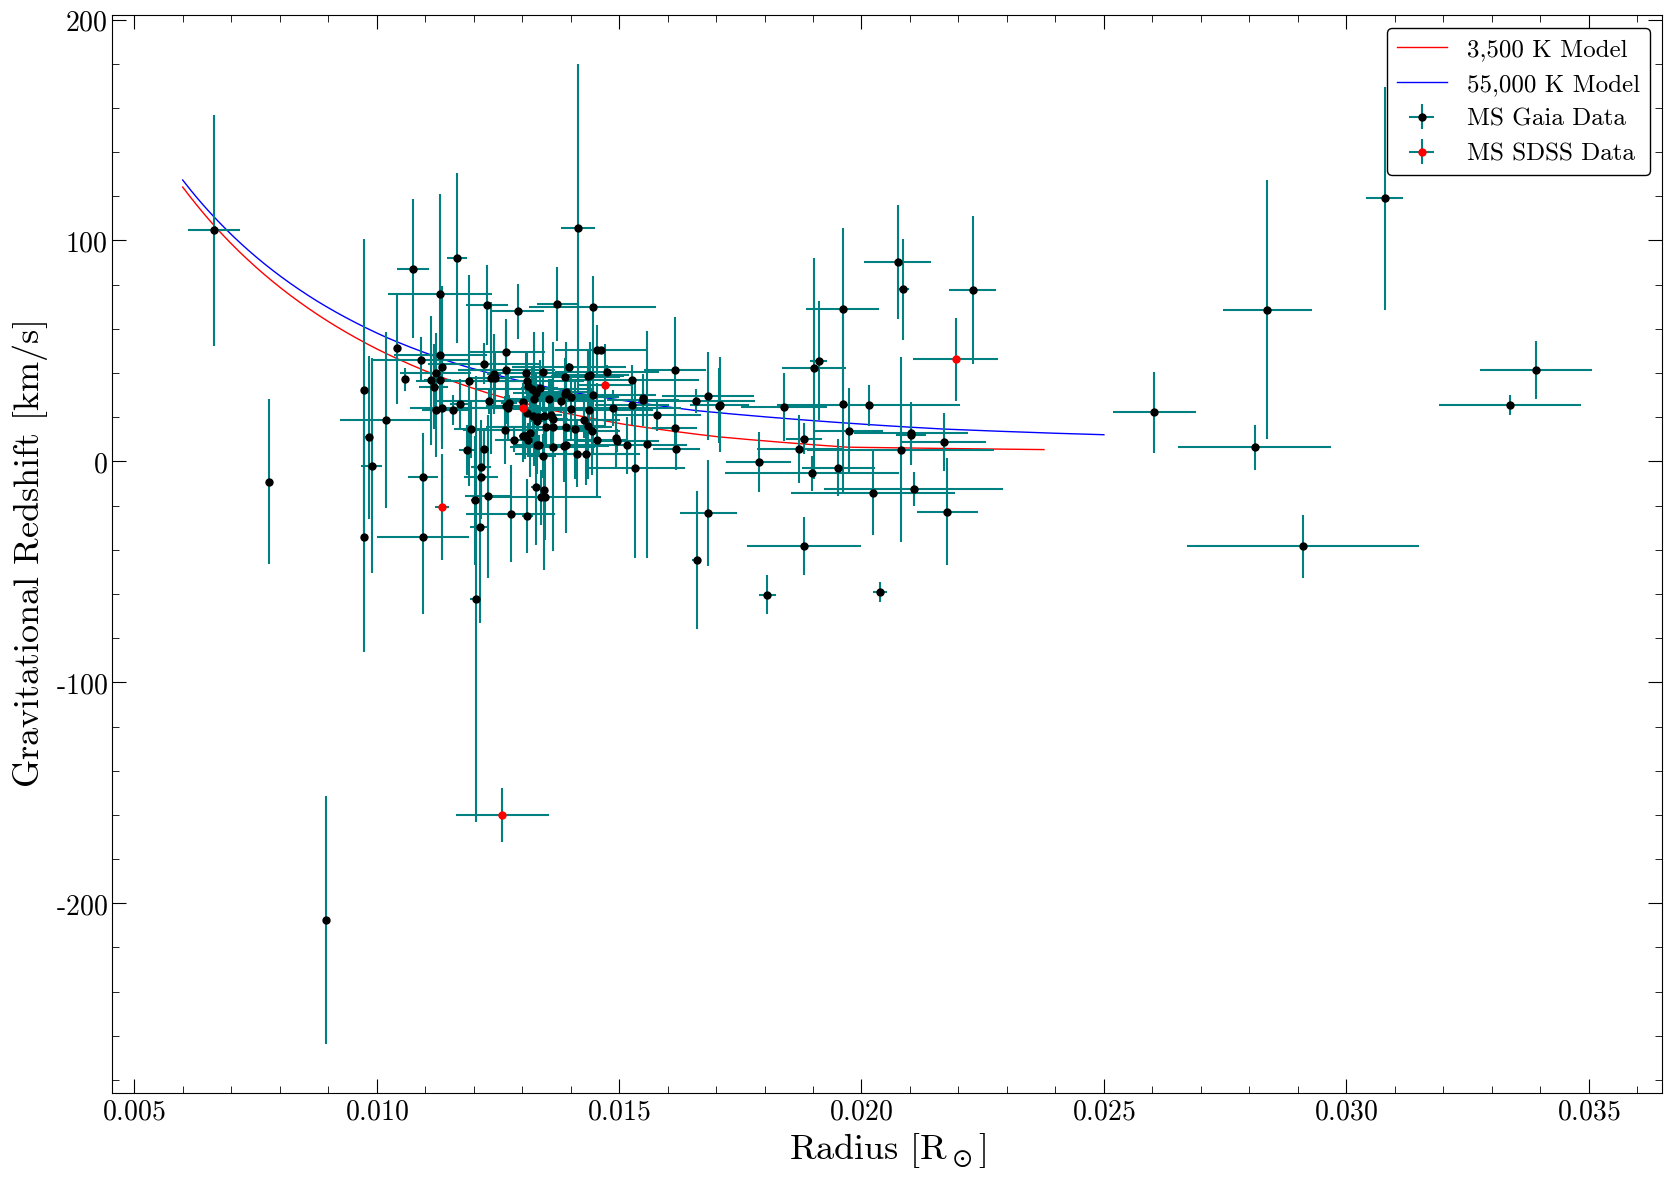

In [8]:
plt.figure(figsize=(20,14))
plt.style.use('./stefan.mplstyle')

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'blue', label = '55,000 K Model', linewidth = 1)

plt.errorbar(catalog[catalog['ms_rv_from'] == 'gaia']['radius'], catalog[catalog['ms_rv_from'] == 'gaia']['g_redshift'], 
             xerr = catalog[catalog['ms_rv_from'] == 'gaia']['e_radius'], yerr=catalog[catalog['ms_rv_from'] == 'gaia']['eg_redshift'], fmt='o', label = 'MS Gaia Data', color='black', ecolor = 'teal')
plt.errorbar(catalog[catalog['ms_rv_from'] != 'gaia']['radius'], catalog[catalog['ms_rv_from'] != 'gaia']['g_redshift'], 
             xerr = catalog[catalog['ms_rv_from'] != 'gaia']['e_radius'], yerr=catalog[catalog['ms_rv_from'] != 'gaia']['eg_redshift'], fmt='o', label = 'MS SDSS Data', color='Red', ecolor = 'teal')

raw_x = catalog['radius']
raw_y = catalog['g_redshift']

raw_dx = catalog['e_radius']
raw_dy = catalog['eg_redshift']

#for i in range(len(catalog['radius'])):
#    x = catalog['radius'][i]
#    y = catalog['g_redshift'][i]
# #   plt.plot(x, y, 'bo')
#    
#    if (0.006 < x < 0.010 and (20 < y < 120)):
#        plt.text(x * (1 - 0.01), y * (1 - 0.01) , ('%2.2f, %2.2f' % (catalog['wd_catalog_id_phot'][i], catalog['wd_catalog_id'][i])), fontsize=11)

plt.xlabel(r'Radius $[R_\odot]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
#plt.xlim(0.002, 0.027)
#plt.ylim(-20, 135)
plt.legend()

In [9]:
print(catalog[catalog['wd_catalog_id'] == 35]['R_chance_align'])

   R_chance_align   
--------------------
0.004624221123407544


In [10]:
not_da = [96]

catalog.remove_rows(not_da)

In [11]:
''' GENERATE MASK FROM FLAGS '''

gaia = np.all([catalog['ms_gaia'] == 1], axis = 0)
falcon = np.all([catalog['wd_rv_from'] == 'falcon'], axis = 0)

rechi = np.all([catalog['wd_rechi'] < 5], axis = 0)
wd_redchi = np.all([catalog['redchi'] < 5], axis = 0)
ms_redchi = np.all([catalog['ms_redchi'] < 1.5], axis = 0)

snr = np.all([catalog['snr'] > 10], axis = 0)
hig_snr = np.all([catalog['snr'] > 30], axis = 0)

chance = np.all([catalog['R_chance_align'] < 0.01], axis = 0)

not_da = np.ones(len(catalog))
for i in range(len(not_da)):
    if catalog['wd_catalog_id'][i] in [143.0, 345]:
        not_da[i] = 0

#corv_err = np.all([catalog['eg_redshift'] < 100], axis = 0)

mask =  np.all([ms_redchi, wd_redchi, rechi, snr, chance, not_da], axis = 0)
hrmask =  np.all([ms_redchi, wd_redchi, rechi, hig_snr, chance, not_da], axis = 0)


from_gaia = np.all([ms_redchi, wd_redchi, rechi, snr, chance, not_da, gaia], axis = 0)
from_sdss= np.all([ms_redchi, wd_redchi, rechi, snr, chance, not_da, ~gaia], axis = 0)
from_falcon= np.all([ms_redchi, wd_redchi, rechi, snr, chance, not_da, falcon], axis = 0)

print(len(catalog[mask]))

148


In [12]:
print(len(catalog[np.all([catalog['radius'] >= 0.015, mask], axis = 0)]))

43


In [13]:
#plt.figure(figsize=(10,10))
#plt.hist(catalog['ms_parallax_over_error'], bins = 20, label = 'All Sample')
#plt.hist(catalog['ms_parallax_over_error'][mask], bins = 20, label = 'Masked')
#
#ymin, ymax = plt.ylim()
#plt.xlim(0,50)
##plt.vlines(np.mean(catalog['phot_teff']), ymin, ymax, linestyles='dashed')
#plt.xlabel(r'Parallax Over Error', fontsize=18)
#plt.legend()

In [38]:
catalog[mask][-1]

solution_id1,solution_id2,source_id1,source_id2,random_index1,random_index2,ref_epoch1,ref_epoch2,ra1,ra2,ra_error1,ra_error2,dec1,dec2,dec_error1,dec_error2,parallax1,parallax2,parallax_error1,parallax_error2,parallax_over_error1,parallax_over_error2,pm1,pm2,pmra1,pmra2,pmra_error1,pmra_error2,pmdec1,pmdec2,pmdec_error1,pmdec_error2,ra_dec_corr1,ra_dec_corr2,ra_parallax_corr1,ra_parallax_corr2,ra_pmra_corr1,ra_pmra_corr2,ra_pmdec_corr1,ra_pmdec_corr2,dec_parallax_corr1,dec_parallax_corr2,dec_pmra_corr1,dec_pmra_corr2,dec_pmdec_corr1,dec_pmdec_corr2,parallax_pmra_corr1,parallax_pmra_corr2,parallax_pmdec_corr1,parallax_pmdec_corr2,pmra_pmdec_corr1,pmra_pmdec_corr2,astrometric_n_obs_al1,astrometric_n_obs_al2,astrometric_n_obs_ac1,astrometric_n_obs_ac2,astrometric_n_good_obs_al1,astrometric_n_good_obs_al2,astrometric_n_bad_obs_al1,astrometric_n_bad_obs_al2,astrometric_gof_al1,astrometric_gof_al2,astrometric_chi2_al1,astrometric_chi2_al2,astrometric_excess_noise1,astrometric_excess_noise2,astrometric_excess_noise_sig1,astrometric_excess_noise_sig2,astrometric_params_solved1,astrometric_params_solved2,astrometric_primary_flag1,astrometric_primary_flag2,nu_eff_used_in_astrometry1,nu_eff_used_in_astrometry2,pseudocolour1,pseudocolour2,pseudocolour_error1,pseudocolour_error2,ra_pseudocolour_corr1,ra_pseudocolour_corr2,dec_pseudocolour_corr1,dec_pseudocolour_corr2,parallax_pseudocolour_corr1,parallax_pseudocolour_corr2,pmra_pseudocolour_corr1,pmra_pseudocolour_corr2,pmdec_pseudocolour_corr1,pmdec_pseudocolour_corr2,astrometric_matched_transits1,astrometric_matched_transits2,visibility_periods_used1,visibility_periods_used2,astrometric_sigma5d_max1,astrometric_sigma5d_max2,matched_transits1,matched_transits2,new_matched_transits1,new_matched_transits2,matched_transits_removed1,matched_transits_removed2,ipd_gof_harmonic_amplitude1,ipd_gof_harmonic_amplitude2,ipd_gof_harmonic_phase1,ipd_gof_harmonic_phase2,ipd_frac_multi_peak1,ipd_frac_multi_peak2,ipd_frac_odd_win1,ipd_frac_odd_win2,ruwe1,ruwe2,scan_direction_strength_k11,scan_direction_strength_k12,scan_direction_strength_k21,scan_direction_strength_k22,scan_direction_strength_k31,scan_direction_strength_k32,scan_direction_strength_k41,scan_direction_strength_k42,scan_direction_mean_k11,scan_direction_mean_k12,scan_direction_mean_k21,scan_direction_mean_k22,scan_direction_mean_k31,scan_direction_mean_k32,scan_direction_mean_k41,scan_direction_mean_k42,duplicated_source1,duplicated_source2,phot_g_n_obs1,phot_g_n_obs2,phot_g_mean_flux1,phot_g_mean_flux2,phot_g_mean_flux_error1,phot_g_mean_flux_error2,phot_g_mean_flux_over_error1,phot_g_mean_flux_over_error2,phot_g_mean_mag1,phot_g_mean_mag2,phot_bp_n_obs1,phot_bp_n_obs2,phot_bp_mean_flux1,phot_bp_mean_flux2,phot_bp_mean_flux_error1,phot_bp_mean_flux_error2,phot_bp_mean_flux_over_error1,phot_bp_mean_flux_over_error2,phot_bp_mean_mag1,phot_bp_mean_mag2,phot_rp_n_obs1,phot_rp_n_obs2,phot_rp_mean_flux1,phot_rp_mean_flux2,phot_rp_mean_flux_error1,phot_rp_mean_flux_error2,phot_rp_mean_flux_over_error1,phot_rp_mean_flux_over_error2,phot_rp_mean_mag1,phot_rp_mean_mag2,phot_bp_n_contaminated_transits1,phot_bp_n_contaminated_transits2,phot_bp_n_blended_transits1,phot_bp_n_blended_transits2,phot_rp_n_contaminated_transits1,phot_rp_n_contaminated_transits2,phot_rp_n_blended_transits1,phot_rp_n_blended_transits2,phot_proc_mode1,phot_proc_mode2,phot_bp_rp_excess_factor1,phot_bp_rp_excess_factor2,bp_rp1,bp_rp2,bp_g1,bp_g2,g_rp1,g_rp2,dr2_radial_velocity1,dr2_radial_velocity2,dr2_radial_velocity_error1,dr2_radial_velocity_error2,dr2_rv_nb_transits1,dr2_rv_nb_transits2,dr2_rv_template_teff1,dr2_rv_template_teff2,dr2_rv_template_logg1,dr2_rv_template_logg2,dr2_rv_template_fe_h1,dr2_rv_template_fe_h2,l1,l2,b1,b2,ecl_lon1,ecl_lon2,ecl_lat1,ecl_lat2,pairdistance,sep_AU,binary_type,Sigma18,R_chance_align,dr2_source_id1,dr2_source_id2,dr2_parallax1,dr2_parallax2,dr2_parallax_error1,dr2_parallax_error2,dr2_pmra1,dr2_pmra2,dr2_pmdec1,dr2_pmdec2,dr2_pmra_error1,dr2

2


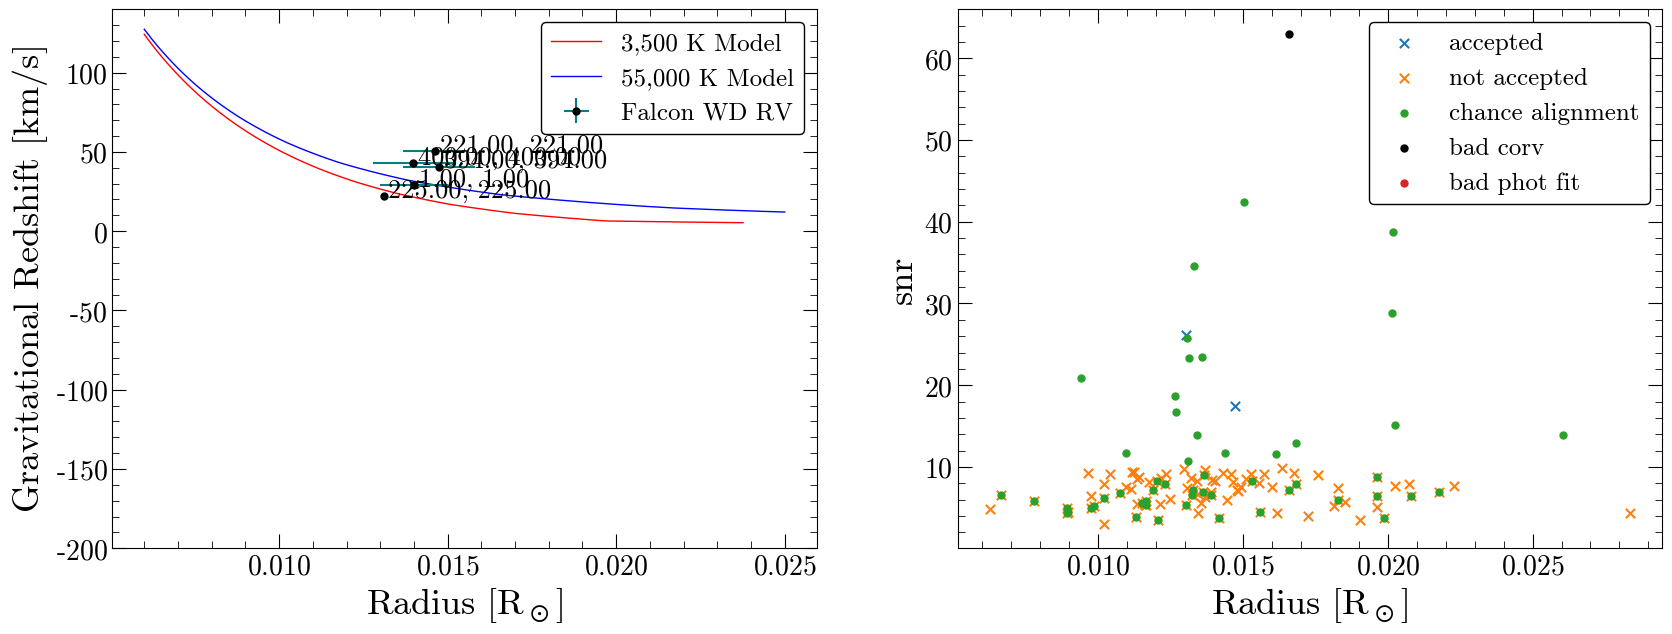

In [15]:
''' PLOTTING '''

plt.figure(figsize=(20,7))

plt.subplot(1,2,1) 

plt.style.use('./stefan.mplstyle')

# Theoretical Tracks

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'blue', label = '55,000 K Model', linewidth = 1)

for i in range(len(catalog['radius'][from_falcon])):
    x = catalog['radius'][from_falcon][i]
    y = catalog['g_redshift'][from_falcon][i]
 #   plt.plot(x, y, 'bo')
    
    #if (0.006 < x < 0.025) and (-50 < y < 120):
    plt.text(x * (1 + 0.01), y * (1 - 0.01) , ('%2.2f, %2.2f' % (catalog['wd_catalog_id_phot'][from_falcon][i], catalog['wd_catalog_id'][from_falcon][i])), fontsize=19)
    
# Data


plt.errorbar(catalog['radius'][from_falcon], catalog['g_redshift'][from_falcon], xerr = catalog['e_radius'][from_falcon], yerr=catalog['eg_redshift'][from_falcon], fmt='o', 
             label = 'Falcon WD RV', color='black', ecolor = 'teal')
#plt.errorbar(catalog['radius'][from_sdss], catalog['g_redshift'][from_sdss], xerr = catalog['e_radius'][from_sdss], yerr=catalog['eg_redshift'][from_sdss], fmt='o', 
#             label = 'SDSS MS RV', color='red', ecolor = 'teal')

print(len(catalog['radius'][from_sdss]))

#plt.errorbar(catalog['radius'][catalog['wd_catalog_id'] == 49], catalog['g_redshift'][catalog['wd_catalog_id'] == 49],
#            xerr = catalog['e_radius'][catalog['wd_catalog_id'] == 49], yerr = catalog['eg_redshift'][catalog['wd_catalog_id'] == 49])

#plt.scatter(catalog['radius'][catalog['wd_catalog_id'] == 26], catalog['g_redshift'][catalog['wd_catalog_id'] == 26])


refs = Table.read('sdss5/ms_gaia_wd_sdss5.fits')
ms_stuff = Table.read('data/ms_sdss4_wd_sdss4.fits')

#for i in range(len(c2)):
#    if (c2['wd_source_id'][i] in refs['wd_source_id']):
#        plt.axvline(x=c2['radius'][i], ls='--', c='red', lw=0.3)
#    elif (c2['wd_source_id'][i] in refs['wd_source_id']):
#        plt.axvline(x=c2['radius'][i], ls=':', c='green', lw=0.3)
#

plt.xlabel(r'Radius $[R_\odot]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
#plt.xlim(0.006, 0.025)
plt.ylim(-200, 140)
plt.legend()

plt.subplot(1,2,2) 

#plt.figure(figsize=(10,7))
plt.style.use('./stefan.mplstyle')


#plt.scatter(catalog['radius'], catalog['snr'], label='base')
plt.scatter(catalog['radius'][from_sdss], catalog['snr'][from_sdss], label='accepted', marker = 'x', s = 45)
plt.scatter(catalog['radius'][~snr], catalog['snr'][~snr], label='not accepted', marker = 'x', s = 45)
plt.scatter(catalog['radius'][~chance], catalog['snr'][~chance], label='chance alignment')
plt.scatter(catalog['radius'][~rechi], catalog['snr'][~rechi], label='bad corv', color = 'black')
plt.scatter(catalog['radius'][~wd_redchi], catalog['snr'][~wd_redchi], label='bad phot fit')


#for i in range(len(catalog['radius'])):
#    x = catalog['radius'][i]
#    y = catalog['snr'][i]
#    plt.text(x * (1 + 0.01), y * (1 - 0.01) , ('%2.2f' % (catalog['wd_catalog_id'][i])), fontsize=11)


plt.xlabel(r'Radius $[R_\odot]$')
plt.ylabel(r'snr')
plt.legend()

In [16]:
x = catalog['radius'][mask]
y = catalog['g_redshift'][mask]

dx = catalog['e_radius'][mask]
dy = catalog['eg_redshift'][mask]

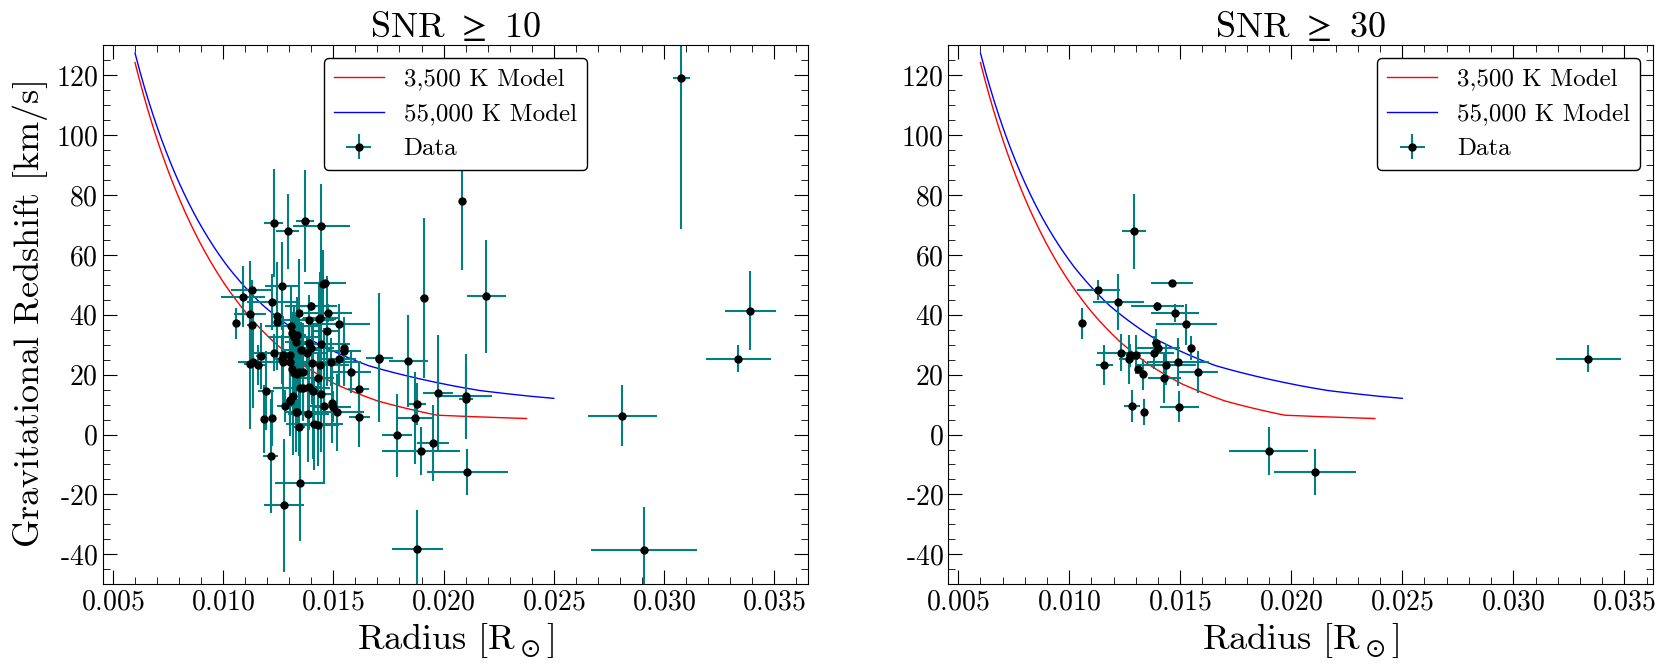

In [17]:
''' PLOTTING '''

fig = plt.figure(figsize=(20,7))
plt.subplot(1,2,1) 
plt.style.use('./stefan.mplstyle')

# Theoretical Tracks

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'blue', label = '55,000 K Model', linewidth = 1)

# Data

plt.errorbar(catalog['radius'][mask], catalog['g_redshift'][mask], xerr = catalog['e_radius'][mask], yerr = catalog['eg_redshift'][mask], fmt='o', label = 'Data', color='black', ecolor = 'teal')

#plt.xticks(fontsize=25)
#plt.yticks(fontsize=25)

plt.ylim(-50, 130)

plt.xlabel(r'Radius $[R_\odot]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.title(r'SNR $\geq$ 10', fontsize=26)
plt.legend()

plt.subplot(1,2,2) 
plt.style.use('./stefan.mplstyle')

# Theoretical Tracks

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'blue', label = '55,000 K Model', linewidth = 1)

# Data

plt.errorbar(catalog['radius'][hrmask], catalog['g_redshift'][hrmask], xerr = catalog['e_radius'][hrmask], yerr = catalog['eg_redshift'][hrmask], fmt='o', label = 'Data', color='black', ecolor = 'teal')

#plt.xticks(fontsize=25)
#plt.yticks(fontsize=25)
plt.ylim(-50, 130)

plt.xlabel(r'Radius $[R_\odot]$')
#plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.title(r'SNR $\geq$ 30', fontsize=26)
plt.legend()
#plt.colorbar()

plt.savefig('spectra/curve_withhighsnr.pdf')

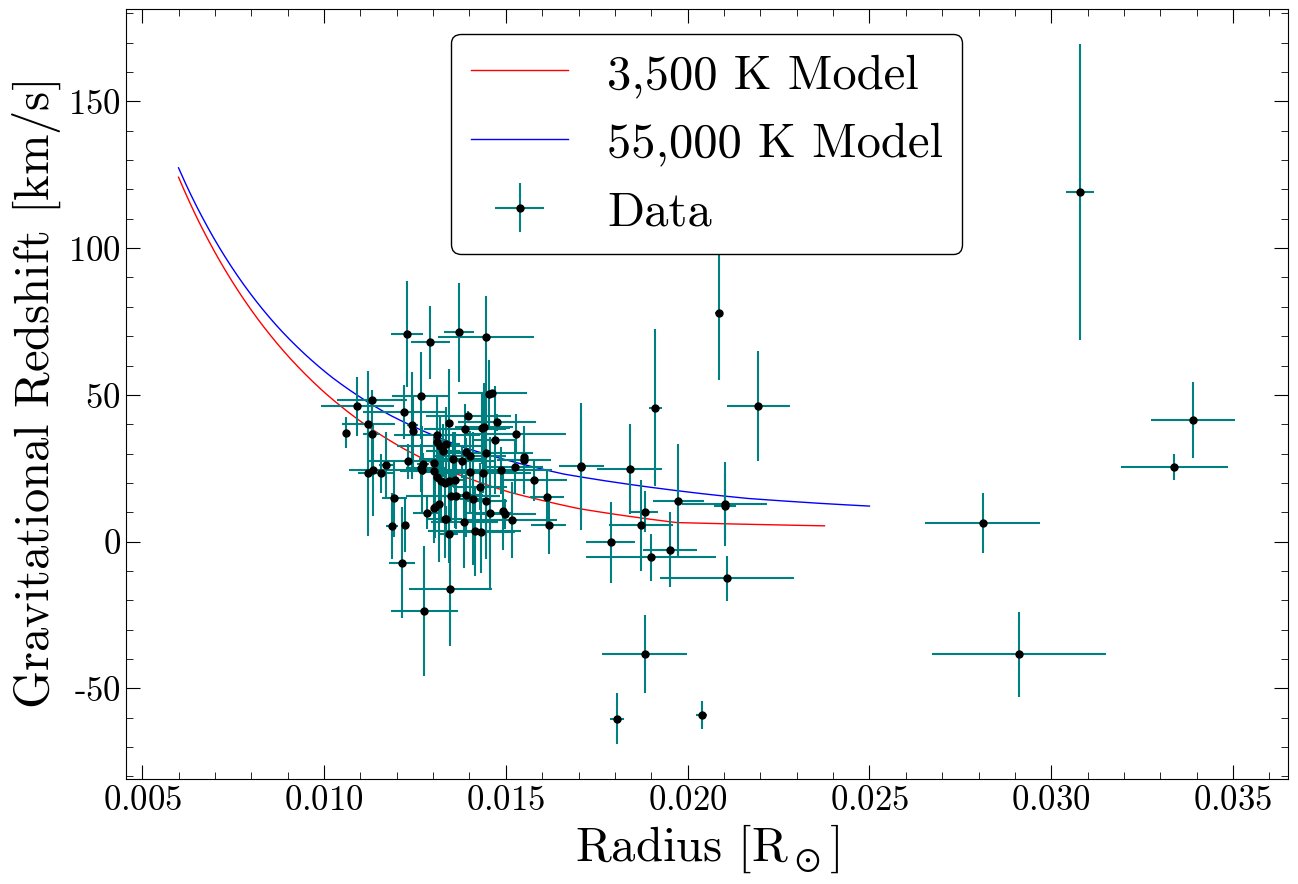

In [18]:
plt.figure(figsize=(15,10))

plt.style.use('./stefan.mplstyle')

# Theoretical Tracks

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'blue', label = '55,000 K Model', linewidth = 1)

domain = np.linspace(min(x), max(x), 100)

plt.errorbar(x, y, xerr = dx, yerr=dy, fmt='o', label = 'Data', color='black', ecolor = 'teal')

plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.xlabel(r'Radius $[R_\odot]$', fontsize=35)
plt.ylabel(r'Gravitational Redshift $[km/s]$', fontsize=35)
#plt.xlim(0.006, 0.025)
#plt.ylim(-30, 75)
plt.legend(fontsize=35)

In [19]:
catalog[mask]

solution_id1,solution_id2,source_id1,source_id2,random_index1,random_index2,ref_epoch1,ref_epoch2,ra1,ra2,ra_error1,ra_error2,dec1,dec2,dec_error1,dec_error2,parallax1,parallax2,parallax_error1,parallax_error2,parallax_over_error1,parallax_over_error2,pm1,pm2,pmra1,pmra2,pmra_error1,pmra_error2,pmdec1,pmdec2,pmdec_error1,pmdec_error2,ra_dec_corr1,ra_dec_corr2,ra_parallax_corr1,ra_parallax_corr2,ra_pmra_corr1,ra_pmra_corr2,ra_pmdec_corr1,ra_pmdec_corr2,dec_parallax_corr1,dec_parallax_corr2,dec_pmra_corr1,dec_pmra_corr2,dec_pmdec_corr1,dec_pmdec_corr2,parallax_pmra_corr1,parallax_pmra_corr2,parallax_pmdec_corr1,parallax_pmdec_corr2,pmra_pmdec_corr1,pmra_pmdec_corr2,astrometric_n_obs_al1,astrometric_n_obs_al2,astrometric_n_obs_ac1,astrometric_n_obs_ac2,astrometric_n_good_obs_al1,astrometric_n_good_obs_al2,astrometric_n_bad_obs_al1,astrometric_n_bad_obs_al2,astrometric_gof_al1,astrometric_gof_al2,astrometric_chi2_al1,astrometric_chi2_al2,astrometric_excess_noise1,astrometric_excess_noise2,astrometric_excess_noise_sig1,astrometric_excess_noise_sig2,astrometric_params_solved1,astrometric_params_solved2,astrometric_primary_flag1,astrometric_primary_flag2,nu_eff_used_in_astrometry1,nu_eff_used_in_astrometry2,pseudocolour1,pseudocolour2,pseudocolour_error1,pseudocolour_error2,ra_pseudocolour_corr1,ra_pseudocolour_corr2,dec_pseudocolour_corr1,dec_pseudocolour_corr2,parallax_pseudocolour_corr1,parallax_pseudocolour_corr2,pmra_pseudocolour_corr1,pmra_pseudocolour_corr2,pmdec_pseudocolour_corr1,pmdec_pseudocolour_corr2,astrometric_matched_transits1,astrometric_matched_transits2,visibility_periods_used1,visibility_periods_used2,astrometric_sigma5d_max1,astrometric_sigma5d_max2,matched_transits1,matched_transits2,new_matched_transits1,new_matched_transits2,matched_transits_removed1,matched_transits_removed2,ipd_gof_harmonic_amplitude1,ipd_gof_harmonic_amplitude2,ipd_gof_harmonic_phase1,ipd_gof_harmonic_phase2,ipd_frac_multi_peak1,ipd_frac_multi_peak2,ipd_frac_odd_win1,ipd_frac_odd_win2,ruwe1,ruwe2,scan_direction_strength_k11,scan_direction_strength_k12,scan_direction_strength_k21,scan_direction_strength_k22,scan_direction_strength_k31,scan_direction_strength_k32,scan_direction_strength_k41,scan_direction_strength_k42,scan_direction_mean_k11,scan_direction_mean_k12,scan_direction_mean_k21,scan_direction_mean_k22,scan_direction_mean_k31,scan_direction_mean_k32,scan_direction_mean_k41,scan_direction_mean_k42,duplicated_source1,duplicated_source2,phot_g_n_obs1,phot_g_n_obs2,phot_g_mean_flux1,phot_g_mean_flux2,phot_g_mean_flux_error1,phot_g_mean_flux_error2,phot_g_mean_flux_over_error1,phot_g_mean_flux_over_error2,phot_g_mean_mag1,phot_g_mean_mag2,phot_bp_n_obs1,phot_bp_n_obs2,phot_bp_mean_flux1,phot_bp_mean_flux2,phot_bp_mean_flux_error1,phot_bp_mean_flux_error2,phot_bp_mean_flux_over_error1,phot_bp_mean_flux_over_error2,phot_bp_mean_mag1,phot_bp_mean_mag2,phot_rp_n_obs1,phot_rp_n_obs2,phot_rp_mean_flux1,phot_rp_mean_flux2,phot_rp_mean_flux_error1,phot_rp_mean_flux_error2,phot_rp_mean_flux_over_error1,phot_rp_mean_flux_over_error2,phot_rp_mean_mag1,phot_rp_mean_mag2,phot_bp_n_contaminated_transits1,phot_bp_n_contaminated_transits2,phot_bp_n_blended_transits1,phot_bp_n_blended_transits2,phot_rp_n_contaminated_transits1,phot_rp_n_contaminated_transits2,phot_rp_n_blended_transits1,phot_rp_n_blended_transits2,phot_proc_mode1,phot_proc_mode2,phot_bp_rp_excess_factor1,phot_bp_rp_excess_factor2,bp_rp1,bp_rp2,bp_g1,bp_g2,g_rp1,g_rp2,dr2_radial_velocity1,dr2_radial_velocity2,dr2_radial_velocity_error1,dr2_radial_velocity_error2,dr2_rv_nb_transits1,dr2_rv_nb_transits2,dr2_rv_template_teff1,dr2_rv_template_teff2,dr2_rv_template_logg1,dr2_rv_template_logg2,dr2_rv_template_fe_h1,dr2_rv_template_fe_h2,l1,l2,b1,b2,ecl_lon1,ecl_lon2,ecl_lat1,ecl_lat2,pairdistance,sep_AU,binary_type,Sigma18,R_chance_align,dr2_source_id1,dr2_source_id2,dr2_parallax1,dr2_parallax2,dr2_parallax_error1,dr2_parallax_error2,dr2_pmra1,dr2_pmra2,dr2_pmdec1,dr2_pmdec2,dr2_pmra_error1,dr2

In [20]:
a = 0
b = 0
c = 0

for i in catalog['wd_rv_from'][mask]:
    if i == 'sdss5':
        a += 1
    elif i == 'sdss4':
        b += 1
    elif i == 'falcon':
        c += 1

print('sdss5: {}'.format(a))
print('sdss4: {}'.format(b))
print('falcon: {}'.format(c))
print('total: {}'.format(a+b+c))

sdss5: 55
sdss4: 88
falcon: 5
total: 148


In [21]:
a = 0
b = 0
c = 0

for i in catalog['ms_rv_from'][mask]:
    if i == 'sdss5':
        a += 1
    elif i == 'sdss4':
        b += 1
    elif i == 'gaia':
        c += 1

print('sdss5: {}'.format(a))
print('sdss4: {}'.format(b))
print('gaia: {}'.format(c))
print('total: {}'.format(a+b+c))

sdss5: 41
sdss4: 4
gaia: 103
total: 148


In [22]:
import scipy.odr as odr

def power(beta, x):
    return beta[0] * x**(-4)#beta[1]# + beta[2]

dat = odr.RealData(x, y, sx = dx, sy = dy)
mod = odr.Model(power)

res = odr.ODR(dat, mod, beta0=[1]).run()

In [23]:
print(res.beta)
print(np.sqrt(np.diag(res.cov_beta)))
print(res.sd_beta)
print(res.res_var)

[nan]
[0.]
[0.]
0.0


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

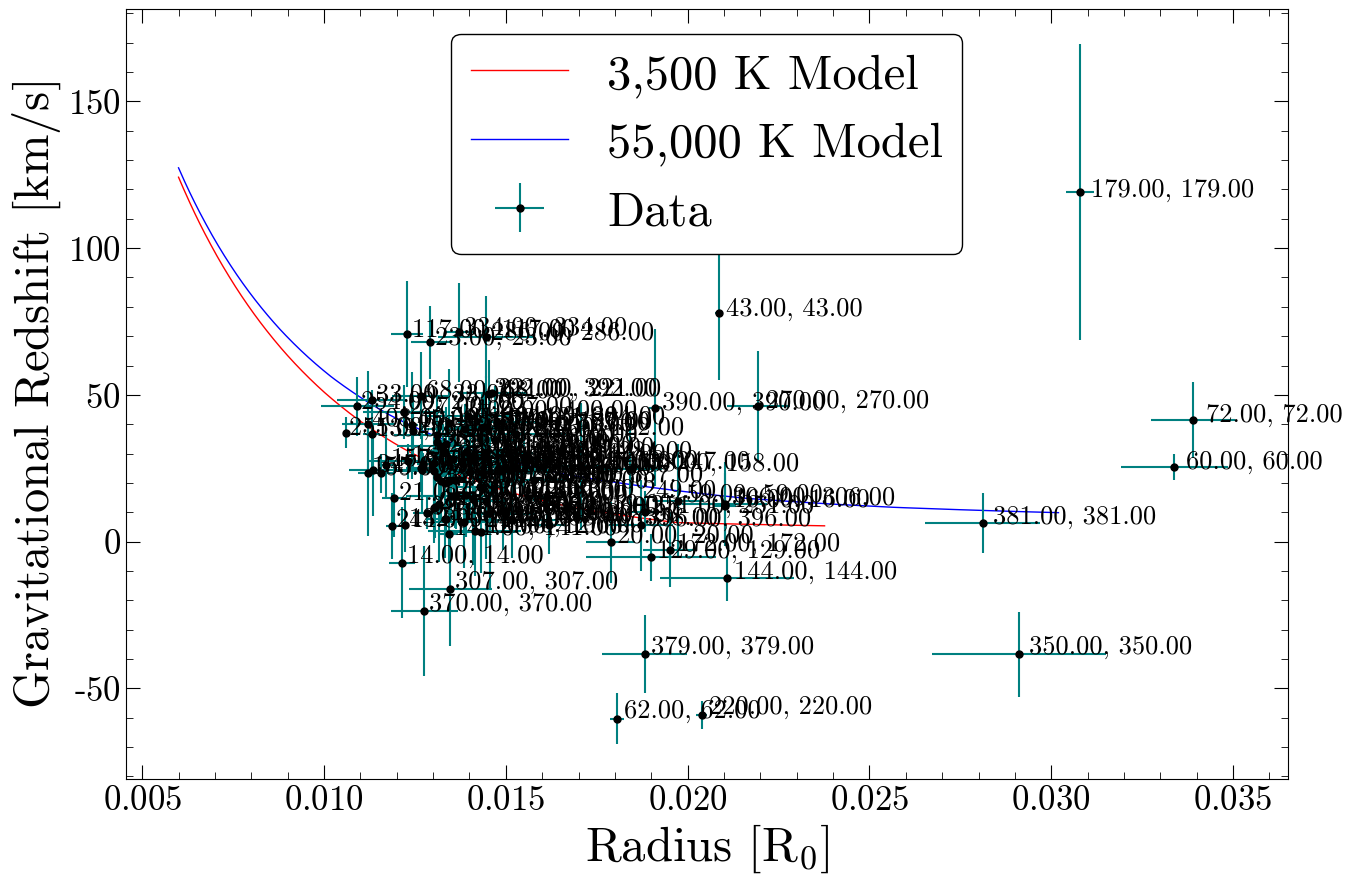

In [24]:
plt.figure(figsize=(15,10))

plt.style.use('./stefan.mplstyle')

# Theoretical Tracks

rsuns = np.linspace(0.006,0.04, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'blue', label = '55,000 K Model', linewidth = 1)

plt.errorbar(catalog['radius'][mask], catalog['g_redshift'][mask], xerr = catalog['e_radius'][mask], yerr=catalog['eg_redshift'][mask], 
             fmt='o', label = 'Data', color='black', ecolor = 'teal')
#plt.errorbar(x, y, xerr = dx, yerr=dy, fmt='o', label = 'Binned Data', color='black', ecolor = 'teal')
#plt.plot(rsuns, power(res.beta, rsuns), lw=2, linestyle='--', color = 'orange', label = 'Model')


for i in range(len(catalog['radius'][mask])):
    x = catalog['radius'][mask][i]
    y = catalog['g_redshift'][mask][i]
 #   plt.plot(x, y, 'bo')
    
    #if (0.006 < x < 0.025) and (-50 < y < 120):
    plt.text(x * (1 + 0.01), y * (1 - 0.01) , ('%2.2f, %2.2f' % (catalog['wd_catalog_id_phot'][mask][i], catalog['wd_catalog_id'][mask][i])), fontsize=19)


#plt.plot(rsuns, power([6.58268098e-07+3.17614822e-08, -3.21018040e+00,  0.00000000e+00], rsuns), lw=1, linestyle='--', color = 'orange')
#plt.plot(rsuns, power([6.58268098e-07-3.17614822e-08, -3.21018040e+00,  0.00000000e+00], rsuns), lw=1, linestyle='--', color = 'orange')


plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.xlabel(r'Radius $[R_{0}]$', fontsize=35)
plt.ylabel(r'Gravitational Redshift $[km/s]$', fontsize=35)
#plt.xlim(0.006, 0.025)
#plt.ylim(-210, 150)
plt.legend(fontsize=35)

plt.savefig('spectra/curve.pdf')

In [25]:
print(np.median(catalog['e_radius'][mask]))

0.0007304182312750504


Text(0, 0.5, 'bp-rp')

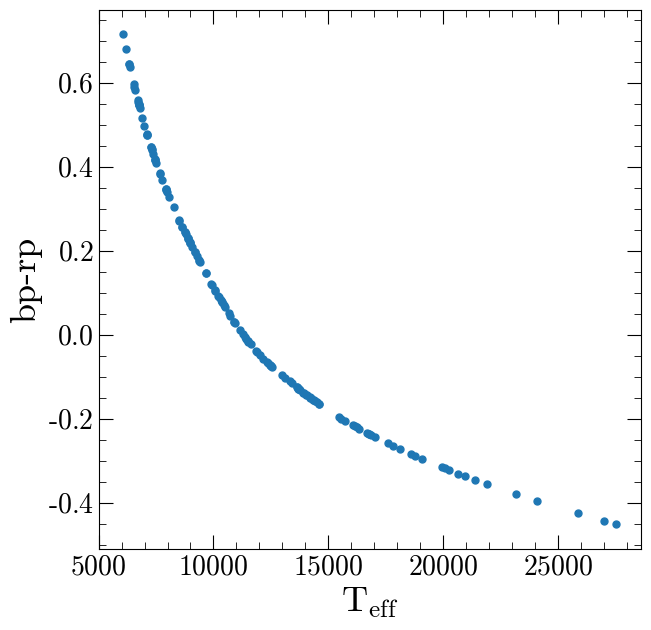

In [26]:
plt.scatter(catalog['phot_teff_2'][mask], catalog['wd_bp_rp'][mask])
plt.xlabel(r'$T_{eff}$')
plt.ylabel('bp-rp')

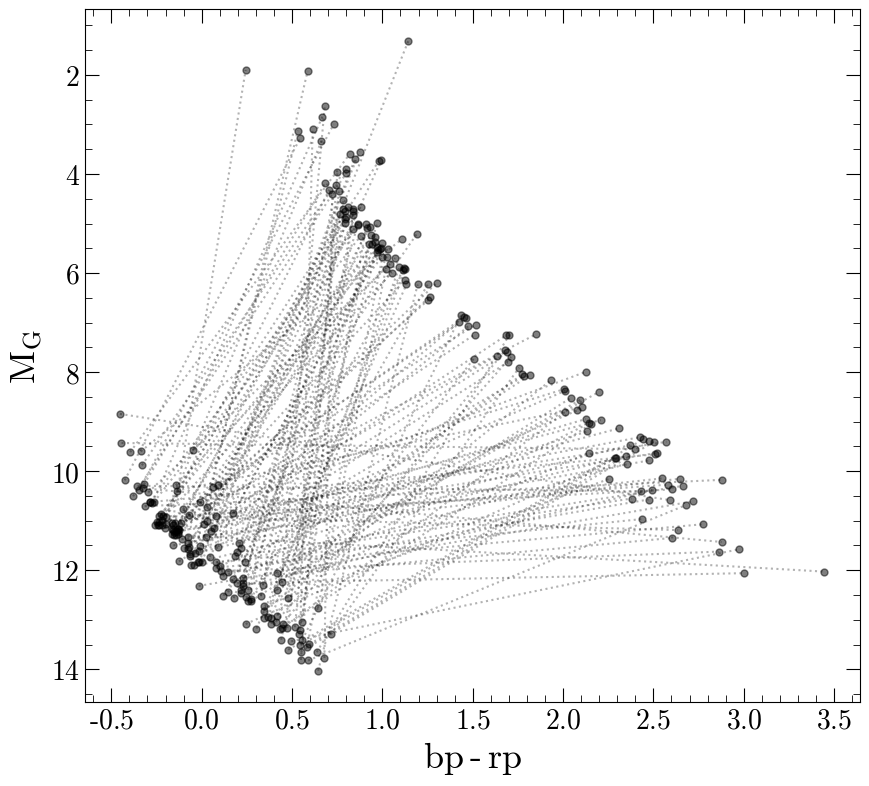

In [27]:
plt.figure(figsize=(10,9))

plt.scatter(catalog['wd_bp_rp'][mask], catalog['wd_m_g'][mask], c = 'k', alpha = 0.5)
plt.scatter(catalog['ms_bp_rp'][mask], catalog['ms_m_g'][mask], c = 'k', alpha = 0.5)

for i in range(len(catalog[mask])):
    plt.plot([catalog['wd_bp_rp'][mask][i], catalog['ms_bp_rp'][mask][i]], [catalog['wd_m_g'][mask][i], catalog['ms_m_g'][mask][i]], c = 'k', ls=':', alpha=0.3)

plt.gca().invert_yaxis()

plt.ylabel(r'$M_G$')
plt.xlabel(r'$bp-rp$')

plt.savefig('spectra/cmd.pdf')

In [28]:
print(catalog.keys())

['solution_id1', 'solution_id2', 'source_id1', 'source_id2', 'random_index1', 'random_index2', 'ref_epoch1', 'ref_epoch2', 'ra1', 'ra2', 'ra_error1', 'ra_error2', 'dec1', 'dec2', 'dec_error1', 'dec_error2', 'parallax1', 'parallax2', 'parallax_error1', 'parallax_error2', 'parallax_over_error1', 'parallax_over_error2', 'pm1', 'pm2', 'pmra1', 'pmra2', 'pmra_error1', 'pmra_error2', 'pmdec1', 'pmdec2', 'pmdec_error1', 'pmdec_error2', 'ra_dec_corr1', 'ra_dec_corr2', 'ra_parallax_corr1', 'ra_parallax_corr2', 'ra_pmra_corr1', 'ra_pmra_corr2', 'ra_pmdec_corr1', 'ra_pmdec_corr2', 'dec_parallax_corr1', 'dec_parallax_corr2', 'dec_pmra_corr1', 'dec_pmra_corr2', 'dec_pmdec_corr1', 'dec_pmdec_corr2', 'parallax_pmra_corr1', 'parallax_pmra_corr2', 'parallax_pmdec_corr1', 'parallax_pmdec_corr2', 'pmra_pmdec_corr1', 'pmra_pmdec_corr2', 'astrometric_n_obs_al1', 'astrometric_n_obs_al2', 'astrometric_n_obs_ac1', 'astrometric_n_obs_ac2', 'astrometric_n_good_obs_al1', 'astrometric_n_good_obs_al2', 'astrometri

In [29]:
print(np.median(catalog['sep_AU'][mask]))

2774.3966005429393


In [30]:
def bin(dat, use_mask = True):
    x = []
    y = []
    
    dx = []
    dy = []
    
    lens = []
        
    if use_mask:
        count, bins = np.histogram(catalog['radius'][mask])

        for i in range(len(bins)-1):
            temp_x = []
            temp_y = []
            
            temp_dx = []
            temp_dy = []
            for j in range(len(catalog[mask])):
                if (catalog['radius'][mask][j] <= bins[i+1]) and (catalog['radius'][mask][j] >= bins[i]):
                    temp_x.append(catalog['radius'][mask][j])
                    temp_y.append(catalog['g_redshift'][mask][j])
                    
                    temp_dx.append(catalog['e_radius'][mask][j])
                    temp_dy.append(catalog['eg_redshift'][mask][j])
                    
            x.append(np.mean(temp_x))
            y.append(np.mean(temp_y))
            
            dx.append( (1 / np.sqrt(len(temp_dx))) *  np.sqrt(sum([x**2 for x in temp_dx])))
            dy.append( (1 / np.sqrt(len(temp_dy))) *  np.sqrt(sum([x**2 for x in temp_dy])))
            
            lens.append(len(temp_x))
    else:
        count, bins = np.histogram(catalog['radius'])
        print(count)

        for i in range(len(bins)-1):
            temp_x = []
            temp_y = []
            
            temp_dx = []
            temp_dy = []
            for j in range(len(catalog)):
                if (catalog['radius'][j] <= bins[i+1]) and (catalog['radius'][j] >= bins[i]):
                    temp_x.append(catalog['radius'][j])
                    temp_y.append(catalog['g_redshift'][j])
                    
                    temp_dx.append(catalog['e_radius'][j])
                    temp_dy.append(catalog['eg_redshift'][j])
                    
            x.append(np.mean(temp_x))
            y.append(np.mean(temp_y))
            
            dx.append( (1 / (len(temp_dx))) *  np.sqrt(sum([x**2 for x in temp_dx])))
            dy.append( (1 / (len(temp_dy))) *  np.sqrt(sum([x**2 for x in temp_dy])))
            
            lens.append(len(temp_x))
            
    return x, y, dx, dy, lens
    
#x, y, dx, dy, lens = bin(catalog, use_mask = True)

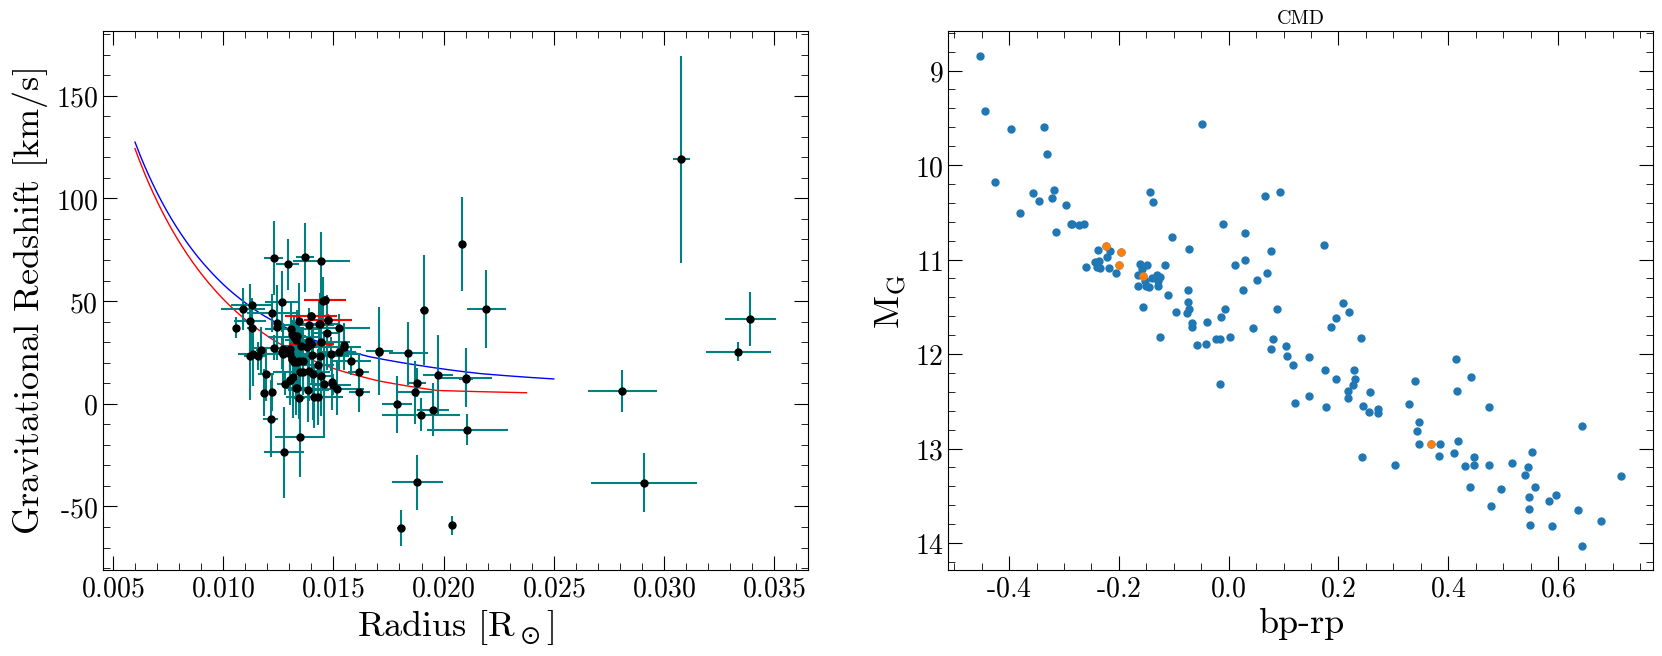

In [31]:
plt.figure(figsize=(20,7))

plt.subplot(1,2,1) 

plt.style.use('./stefan.mplstyle')

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'blue', label = '55,000 K Model', linewidth = 1)


plt.errorbar(catalog['radius'][mask], catalog['g_redshift'][mask], xerr = catalog['e_radius'][mask], yerr = catalog['eg_redshift'][mask], fmt='o', label = 'Data', color='black', ecolor = 'teal')
plt.errorbar(catalog['radius'][from_falcon], catalog['g_redshift'][from_falcon], xerr = catalog['e_radius'][from_falcon], yerr = catalog['eg_redshift'][from_falcon], fmt='o', label = 'Data', color='black', ecolor = 'red')

#
#for i in range(len(catalog['radius'][mask])):
#    x = catalog['radius'][mask][i]
#    y = catalog['g_redshift'][mask][i]
#    plt.text(x, y , ('%2.2f' % (catalog['wd_catalog_id_phot'][mask][i])), fontsize=11)
    
plt.xlabel(r'Radius $[R_\odot]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')

plt.subplot(1,2,2) 

plt.style.use('./stefan.mplstyle')
plt.scatter(catalog['wd_bp_rp'][mask], catalog['wd_m_g'][mask])
plt.scatter(catalog['wd_bp_rp'][from_falcon], catalog['wd_m_g'][from_falcon])

#for i in range(len(catalog['radius'][mask])):
#    x = catalog['wd_bp_rp'][mask][i]
#    y = catalog['wd_m_g'][mask][i]
#    plt.text(x * (1 + 0.001), y * (1 - 0.001) , ('%2.2f' % (catalog['wd_catalog_id_phot'][mask][i])), fontsize=11)
    
plt.ylabel(r'$M_G$')
plt.xlabel(r'bp-rp')
plt.title(r'CMD')
plt.gca().invert_yaxis()

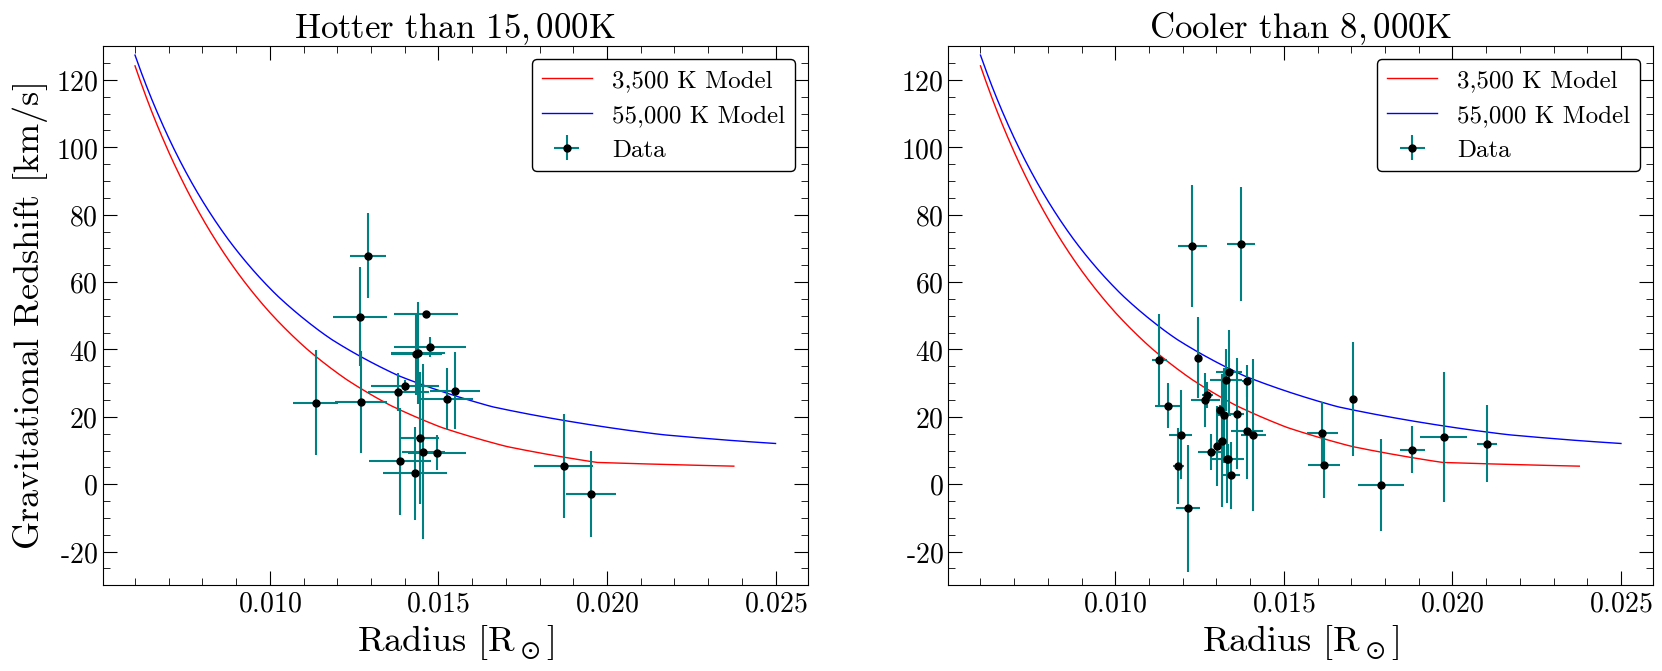

In [32]:
hot_catalog = np.all([catalog['phot_teff_1'] > 15000], axis = 0)
cool_catalog = np.all([catalog['phot_teff_1'] < 8000], axis = 0)

hot_mask = np.all([hot_catalog, mask], axis = 0)

cool_mask = np.all([cool_catalog, mask], axis = 0)

''' PLOTTING '''

plt.figure(figsize=(20,7))
plt.subplot(1,2,1) 
plt.style.use('./stefan.mplstyle')

# Theoretical Tracks

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'blue', label = '55,000 K Model', linewidth = 1)

# Data

plt.errorbar(catalog['radius'][hot_mask], catalog['g_redshift'][hot_mask], xerr = catalog['e_radius'][hot_mask],
             yerr=catalog['eg_redshift'][hot_mask], fmt='o', label = 'Data', color='black', ecolor = 'teal')

#plt.xticks(fontsize=25)
#plt.yticks(fontsize=25)

plt.xlabel(r'Radius $[R_\odot]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.title(r'Hotter than $15,000$K', fontsize=25)
plt.ylim((-30,130))
plt.legend()

plt.subplot(1,2,2) 
plt.style.use('./stefan.mplstyle')

# Theoretical Tracks

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'blue', label = '55,000 K Model', linewidth = 1)

# Data

plt.errorbar(catalog['radius'][cool_mask], catalog['g_redshift'][cool_mask], xerr = catalog['e_radius'][cool_mask], 
             yerr=catalog['eg_redshift'][cool_mask], fmt='o', label = 'Data', color='black', ecolor = 'teal')

#plt.xticks(fontsize=25)
#plt.yticks(fontsize=25)

plt.xlabel(r'Radius $[R_\odot]$')
#plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.title(r'Cooler than $8,000$K', fontsize=25)
plt.ylim((-30,130))

plt.legend()

plt.savefig('spectra/temps_2plots.pdf')

Text(0.5, 0, '$T_{eff}$')

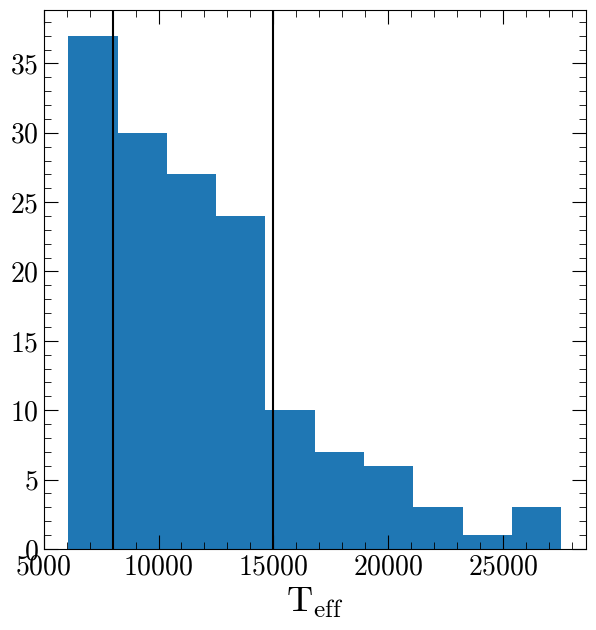

In [33]:
plt.hist(catalog['phot_teff_1'][mask])
plt.axvline(8000, c='k')
plt.axvline(15000, c='k')
plt.xlabel(r'$T_{eff}$')

In [ ]:
hot_catalog = np.all([catalog['phot_teff_1'] > 15000], axis = 0)
cool_catalog = np.all([catalog['phot_teff_1'] < 8000], axis = 0)

hot_mask = np.all([hot_catalog, mask], axis = 0)

cool_mask = np.all([cool_catalog, mask], axis = 0)

''' PLOTTING '''

fig = plt.figure(figsize=(20,7))
plt.subplot(1,2,1) 
plt.style.use('./stefan.mplstyle')

# Theoretical Tracks

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'blue', label = '55,000 K Model', linewidth = 1)

# Data

print(np.log10(catalog['phot_teff_1'][cool_mask]))

a = plt.scatter(catalog['radius'][hot_mask], catalog['g_redshift'][hot_mask],
             c=np.log10(catalog['phot_teff_1'][hot_mask]), cmap = plt.cm.Spectral, zorder = 10, vmin=min(np.log10(catalog['phot_teff_1'][mask])), vmax=max(np.log10(catalog['phot_teff_1'][mask])),
              s = 50, edgecolor='k', lw = 0.75)

plt.errorbar(catalog['radius'][hot_mask], catalog['g_redshift'][hot_mask], xerr = catalog['e_radius'][hot_mask], yerr = catalog['eg_redshift'][hot_mask], fmt=' ', ecolor = 'black')

#plt.xticks(fontsize=25)
#plt.yticks(fontsize=25)

plt.ylim((-30,130))

plt.xlabel(r'Radius $[R_\odot]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.title(r'Hotter Than $15,000$K', fontsize = 25)
plt.legend()

plt.subplot(1,2,2) 
plt.style.use('./stefan.mplstyle')

# Theoretical Tracks

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'blue', label = '55,000 K Model', linewidth = 1)

# Data

a = plt.scatter(catalog['radius'][cool_mask], catalog['g_redshift'][cool_mask],
             c=np.log10(catalog['phot_teff_1'][cool_mask]), cmap = plt.cm.Spectral, zorder = 10, vmin=min(np.log10(catalog['phot_teff_1'][mask])), vmax=max(np.log10(catalog['phot_teff_1'][mask])),
               s = 50, edgecolor='k', lw = .75)

plt.errorbar(catalog['radius'][cool_mask], catalog['g_redshift'][cool_mask], xerr = catalog['e_radius'][cool_mask], yerr = catalog['eg_redshift'][cool_mask], fmt=' ', ecolor = 'black')

#plt.xticks(fontsize=25)
#plt.yticks(fontsize=25)

plt.xlabel(r'Radius $[R_\odot]$')
plt.ylim((-30,130))

#plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.title(r'Cooler Than $8,000$K', fontsize=25)
plt.legend()
#plt.colorbar()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.825, 0.15, 0.02, 0.7])
cbar = fig.colorbar(a, cax=cbar_ax)
cbar.ax.get_yaxis().labelpad = 30
cbar.set_label(r'$log_{10}T_{eff}$ $[dex]$', rotation = 270)

plt.savefig('spectra/temps_2plots_color.pdf')

   phot_teff_1    
------------------
 3.828786575192819
3.8637755529445226
3.7832126722175023
3.8294070360487815
3.8751434339162776
3.8733904818682388
 3.899062095571102
3.8168622918748802
3.8019267049919536
 3.872987655765887
               ...
 3.884573097997234
 3.872247326930285
3.7925940485246126
 3.861981947704389
 3.826261903200662
3.8448533124362956
 3.827496861387852
3.8617037381229533
3.8145799408075027
3.8295498620971857
Length = 36 rows
Error in callback <function flush_figures at 0x7f27c3784a60> (for post_execute):


In [35]:
a

In [36]:
print(min(catalog['ms_parallax_over_error_1'][mask]))

6.88493


In [36]:
plt.hist(catalog['ms_parallax_over_error_1'][mask], bins = 500)
#plt.xlim(0,100)
plt.axvline(x = 10, c = 'black')


KeyboardInterrupt



In [ ]:
plt.figure(figsize=(10,7))

plt.style.use('./stefan.mplstyle')

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'blue', label = '55,000 K Model', linewidth = 1)


colors = plt.cm.Spectral(catalog['phot_teff_1'])

plt.scatter(catalog['radius'][mask], catalog['g_redshift'][mask], label = 'Data', 
             c=catalog['phot_teff_1'][mask], cmap = plt.cm.Spectral, zorder = 10)

plt.errorbar(catalog['radius'][mask], catalog['g_redshift'][mask], xerr = catalog['e_radius'][mask], yerr = catalog['eg_redshift'][mask], fmt=' ', label = 'Data',ecolor = 'black', alpha = 0.5)
#plt.errorbar(catalog['radius'][from_falcon], catalog['g_redshift'][from_falcon], xerr = catalog['e_radius'][from_falcon], yerr = catalog['eg_redshift'][from_falcon], fmt='o', label = 'Data',  
#             colors=colors, ecolor = 'teal')



    
plt.xlabel(r'Radius $[R_{0}]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.colorbar()

In [ ]:
rvs_10000 = rv_from_radius(rsuns, 10000, 'f', 'f', 'f')
ts = []

for i in range(len(catalog)):
    exp = np.interp(catalog['radius'][i], rsuns, rvs_10000)
    
    t = (catalog['g_redshift'][i] - exp) / (catalog['eg_redshift'][i])
    ts.append(t)
    
catalog['t_from_10000'] = ts

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


     g_redshift    
-------------------
 29.038538455963135
  3.248886613699643
  9.327819526537553
-160.01650789181923
  67.88574339113444
 13.649380671435345
  49.74030708535437
  27.39429720688093
  24.37944377063149
  38.91409673503536
  9.641689639414954
  50.46513366699219
  6.816071137004812
  14.29008392144766
  24.24047207840001
   38.6358034513023
   40.6515417098999
KstestResult(statistic=0.2338935574229692, pvalue=0.43706823917295445, statistic_location=37.769615819729054, statistic_sign=-1)


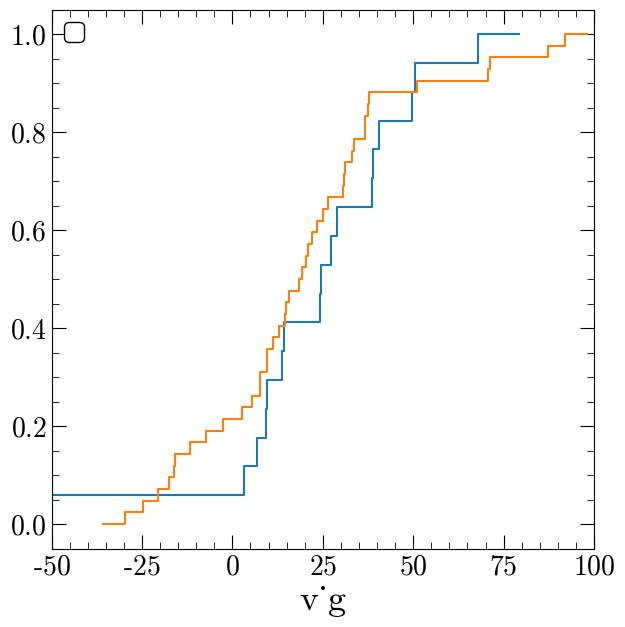

In [42]:
from scipy import stats

# https://halweb.uc3m.es/esp/Personal/personas/dpena/articles/kolpl97.pdf

mid_radius = np.all([catalog['radius'] < 0.015, catalog['radius'] > 0.01], axis = 0)
hot_rad_mask = np.all([hot_catalog, mid_radius, ~np.isnan(catalog['g_redshift'])], axis = 0)
cool_rad_mask = np.all([cool_catalog, mid_radius, ~np.isnan(catalog['g_redshift'])], axis = 0)

#plt.hist(catalog['g_redshift'][hot_rad_mask], alpha = 0.5, label = 'Hot Stars', density=True, cumulative=1)
#plt.hist(catalog['g_redshift'][cool_rad_mask], alpha = 0.5, label = 'Cool Stars', density=True, cumulative=1)

#plt.axvline(x = np.mean(catalog['g_redshift'][hot_rad_mask], alpha = 0.3))

print(catalog['g_redshift'][hot_rad_mask])

hot_res = stats.ecdf(catalog['g_redshift'][hot_rad_mask])
cool_res = stats.ecdf(catalog['g_redshift'][cool_rad_mask])

ax = plt.subplot()

hot_res.cdf.plot(ax)
cool_res.cdf.plot(ax)

print(stats.ks_2samp(catalog['g_redshift'][hot_rad_mask], catalog['g_redshift'][cool_rad_mask]))

plt.xlim(-50,100)
#plt.xticks(range(-10, 10), fontsize = 10)
plt.xlabel(r'v_g')
plt.legend()

In [ ]:
print(np.mean(catalog['t_from_10000'][cool_mask]))

In [ ]:
import os

for i in range(len(catalog[mask])):
    id_ = catalog['wd_catalog_id'][mask][i]
    
    os.system('cp spectra/corvfits/corvfit{}.jpg spectra/good_corvfits/'.format(int(id_)))
    
#for i in range(len(catalog[~clean])):
#    id_ = catalog['wd_catalog_id_phot'][~clean][i]
#    
#    os.system('cp spectra/leastsq/phot_fit/{}.png spectra/leastsq/unclean/'.format(int(id_)))